In [27]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, BatchNormalization, Concatenate, Dropoutout
from keras.layers import Input
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.models import Model
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
train = pd.read_json('data/train/processed/train.json')
test = pd.read_json('data/test/processed/test.json')

In [3]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
print(train.shape, test.shape)
print(len(train['band_1'][0])) #75*75

(1604, 5) (8424, 4)
5625


In [5]:
train['band_1'] = train['band_1'].apply(lambda x: np.reshape(x, [75,75]))
train['band_2'] = train['band_2'].apply(lambda x: np.reshape(x, [75,75]))

In [6]:
train['inc_angle'] = pd.to_numeric(train['inc_angle'], errors = 'coerce')
train['inc_angle'] = train['inc_angle'].fillna(value = train['inc_angle'].mean())

In [7]:
def drawBands(band1, band2):
    band1 = np.reshape(band1, [75,75])
    band2 = np.reshape(band2, [75,75])
    plt.imshow(band1, interpolation = 'nearest')    
    plt.show()
    plt.imshow(band2, interpolation = 'nearest')
    plt.show()

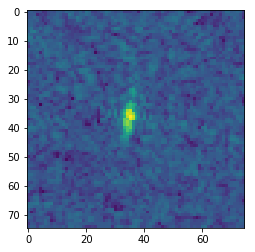

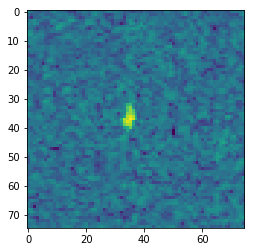

In [8]:
drawBands(train['band_1'][0], train['band_2'][0])

In [51]:
image_input = Input(shape = (75,75,2))
x = BatchNormalization(axis = -1, input_shape= [75,75,2])(image_input)
x = Conv2D(filters = 32, kernel_size = (3,3), activation='relu')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling2D((3,3))(x)
x = Conv2D(filters = 64, kernel_size = (3,3), activation='relu')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling2D((3,3))(x)
x = Conv2D(filters = 64, kernel_size = (3,3), activation='relu')(x)
x = BatchNormalization(axis = -1)(x)
x = MaxPooling2D((3,3))(x)
x = Flatten()(x)
inc_input = Input(shape = (1,)) #incidence angle
x = Concatenate()([x,inc_input])
x = Dense(200, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

In [52]:
dataInput = []
for i in train.index:
    dataInput.append(np.stack([train.loc[i]['band_1'], train.loc[i]['band_2']], axis = -1))
dataInput = np.array(dataInput)

In [53]:
np.random.seed(10)
indexTrain = np.random.choice(range(train.shape[0]), size = int(0.9*train.shape[0]), replace = False)
indexVal = list(set(range(train.shape[0])) - set(indexTrain))
dataInputTrain = dataInput[indexTrain]
dataInputVal = dataInput[indexVal]
traindf = train.loc[indexTrain]
valdf = train.loc[indexVal]

In [54]:
model = Model(inputs = [image_input, inc_input], outputs= x)

In [55]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 75, 75, 2)    8           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 73, 73, 32)   608         batch_normalization_16[0][0]     
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 73, 73, 32)   128         conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [56]:
model.compile(Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

In [57]:
with tf.device('/device:GPU:0'):
    model.fit([dataInputTrain, traindf.inc_angle.values], traindf.is_iceberg.values, epochs = 2, batch_size=32,
               validation_data = ([dataInputVal, valdf.inc_angle.values], valdf.is_iceberg.values), shuffle = True)

Train on 1443 samples, validate on 161 samples
Epoch 1/2
1443/1443 [==============================] - 3s 2ms/step - loss: 0.7797 - acc: 0.5426 - val_loss: 0.8685 - val_acc: 0.4783
Epoch 2/2
1443/1443 [==============================] - 2s 1ms/step - loss: 0.7133 - acc: 0.5696 - val_loss: 0.8062 - val_acc: 0.4783


In [58]:
model.optimizer.lr = 1e-4
model.fit([dataInputTrain, traindf.inc_angle.values], traindf.is_iceberg.values, epochs = 5, batch_size=32,
               validation_data = ([dataInputVal, valdf.inc_angle.values], valdf.is_iceberg.values), shuffle = True)

Train on 1443 samples, validate on 161 samples
Epoch 1/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.6806 - acc: 0.6098 - val_loss: 0.7715 - val_acc: 0.4783
Epoch 2/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.6460 - acc: 0.6362 - val_loss: 0.7504 - val_acc: 0.4845
Epoch 3/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.6310 - acc: 0.6493 - val_loss: 0.7286 - val_acc: 0.5280
Epoch 4/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.6243 - acc: 0.6556 - val_loss: 0.7063 - val_acc: 0.5528
Epoch 5/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.5963 - acc: 0.6722 - val_loss: 0.6801 - val_acc: 0.5776


In [59]:
model.optimizer.lr = 1e-3
model.fit([dataInputTrain, traindf.inc_angle.values], traindf.is_iceberg.values, epochs = 5, batch_size=32,
               validation_data = ([dataInputVal, valdf.inc_angle.values], valdf.is_iceberg.values), shuffle = True)

Train on 1443 samples, validate on 161 samples
Epoch 1/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.5837 - acc: 0.6764 - val_loss: 0.6507 - val_acc: 0.6211
Epoch 2/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.5760 - acc: 0.6951 - val_loss: 0.6300 - val_acc: 0.6522
Epoch 3/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.5749 - acc: 0.6778 - val_loss: 0.6021 - val_acc: 0.6770
Epoch 4/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.5715 - acc: 0.6965 - val_loss: 0.5837 - val_acc: 0.7081
Epoch 5/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.5599 - acc: 0.7159 - val_loss: 0.5678 - val_acc: 0.7205


In [60]:
model.optimizer.lr = 1e-3
model.fit([dataInputTrain, traindf.inc_angle.values], traindf.is_iceberg.values, epochs = 20, batch_size=32,
               validation_data = ([dataInputVal, valdf.inc_angle.values], valdf.is_iceberg.values), shuffle = True)

Train on 1443 samples, validate on 161 samples
Epoch 1/20
1443/1443 [==============================] - 2s 1ms/step - loss: 0.5394 - acc: 0.7214 - val_loss: 0.5544 - val_acc: 0.7329
Epoch 2/20
1443/1443 [==============================] - 2s 1ms/step - loss: 0.5378 - acc: 0.7339 - val_loss: 0.5427 - val_acc: 0.7391
Epoch 3/20
1443/1443 [==============================] - 2s 1ms/step - loss: 0.5354 - acc: 0.7318 - val_loss: 0.5358 - val_acc: 0.7453
Epoch 4/20
1443/1443 [==============================] - 2s 1ms/step - loss: 0.5170 - acc: 0.7311 - val_loss: 0.5311 - val_acc: 0.7453
Epoch 5/20
1443/1443 [==============================] - 2s 1ms/step - loss: 0.5281 - acc: 0.7207 - val_loss: 0.5254 - val_acc: 0.7453
Epoch 6/20
1443/1443 [==============================] - 2s 1ms/step - loss: 0.5002 - acc: 0.7401 - val_loss: 0.5186 - val_acc: 0.7453
Epoch 7/20
1443/1443 [==============================] - 2s 1ms/step - loss: 0.5057 - acc: 0.7339 - val_loss: 0.5116 - val_acc: 0.7516
Epoch 8/20
1443

In [61]:
model.optimizer.lr = 5e-3
model.fit([dataInputTrain, traindf.inc_angle.values], traindf.is_iceberg.values, epochs = 5, batch_size=32,
               validation_data = ([dataInputVal, valdf.inc_angle.values], valdf.is_iceberg.values), shuffle = True)

Train on 1443 samples, validate on 161 samples
Epoch 1/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.4338 - acc: 0.7983 - val_loss: 0.4449 - val_acc: 0.7888
Epoch 2/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.4339 - acc: 0.7893 - val_loss: 0.4428 - val_acc: 0.7888
Epoch 3/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.4310 - acc: 0.7935 - val_loss: 0.4439 - val_acc: 0.7826
Epoch 4/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.4261 - acc: 0.7935 - val_loss: 0.4423 - val_acc: 0.7826
Epoch 5/5
1443/1443 [==============================] - 2s 1ms/step - loss: 0.4172 - acc: 0.8101 - val_loss: 0.4367 - val_acc: 0.7826


In [64]:
model.optimizer.lr = 1e-3
model.fit([dataInputTrain, traindf.inc_angle.values], traindf.is_iceberg.values, epochs = 50, batch_size=32,
               validation_data = ([dataInputVal, valdf.inc_angle.values], valdf.is_iceberg.values), shuffle = True)

Train on 1443 samples, validate on 161 samples
Epoch 1/50
1443/1443 [==============================] - 2s 1ms/step - loss: 0.3658 - acc: 0.8316 - val_loss: 0.4122 - val_acc: 0.8199
Epoch 2/50
1443/1443 [==============================] - 2s 1ms/step - loss: 0.3723 - acc: 0.8219 - val_loss: 0.4114 - val_acc: 0.8199
Epoch 3/50
1443/1443 [==============================] - 2s 1ms/step - loss: 0.3648 - acc: 0.8288 - val_loss: 0.4099 - val_acc: 0.8137
Epoch 4/50
1443/1443 [==============================] - 2s 1ms/step - loss: 0.3674 - acc: 0.8274 - val_loss: 0.4065 - val_acc: 0.8199
Epoch 5/50
1443/1443 [==============================] - 2s 1ms/step - loss: 0.3529 - acc: 0.8420 - val_loss: 0.4036 - val_acc: 0.8199
Epoch 6/50
1443/1443 [==============================] - 2s 1ms/step - loss: 0.3547 - acc: 0.8475 - val_loss: 0.3997 - val_acc: 0.8137
Epoch 7/50
1443/1443 [==============================] - 2s 1ms/step - loss: 0.3639 - acc: 0.8337 - val_loss: 0.3966 - val_acc: 0.8199
Epoch 8/50
1443

## Test Submission

In [65]:
test['band_1'] = test['band_1'].apply(lambda x: np.reshape(x, [75,75]))
test['band_2'] = test['band_2'].apply(lambda x: np.reshape(x, [75,75]))

In [66]:
dataTest = []
for i in test.index:
    dataTest.append(np.stack([test.loc[i]['band_1'], test.loc[i]['band_2']], axis = -1))
dataTest = np.array(dataTest)

In [68]:
ans = model.predict([dataTest, test.inc_angle.values])

In [80]:
ans = np.clip(ans, 0.05, 0.95)

In [81]:
df = pd.DataFrame({'id': test['id'], 'is_iceberg': np.ravel(ans)})

In [82]:
df.head()

,id,is_iceberg
0,5941774d,0.106398
1,4023181e,0.172213
2,b20200e4,0.078767
3,e7f018bb,0.950000
4,4371c8c3,0.515730


In [83]:
df.to_csv('data/answers/simpleCNN.csv', index = False)

In [ ]:
# todos
# data augmentation
# pseudo labelling